In this notebook, we use the Capital Asset Pricing Model (CAPM) to estimate the value of a given stock (IBM) against the "market" (represented by the S&P500)

In CAPM we assume the returns of an asset is some risk-free rate plus the market-risk premium, with beta as a proportionality constant. Beta is a measure of the volatility of a stock/portfolio with respect to the market volatility.

In [110]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

### Download stock and "market" data

In [111]:
STOCKS = ["IBM", "^GSPC"]
start_date = "2010-01-01"
end_date = "2023-01-01"

In [112]:
data = {}
for s in STOCKS:
    ticker = yf.download(s, start=start_date, end=end_date)
    data[s] = ticker["Adj Close"]
ticker_data = pd.DataFrame(data)
ticker_data.index = pd.to_datetime(ticker_data.index)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Check normality of daily returns

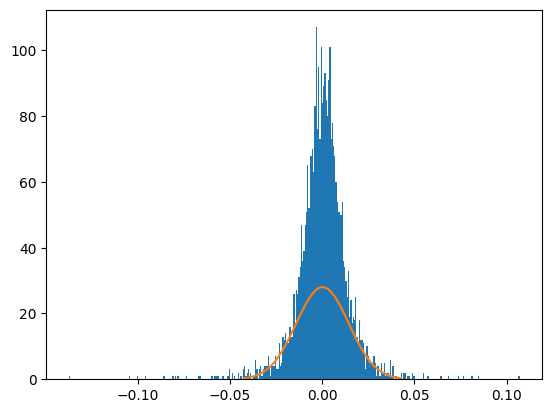

In [127]:
log_daily_returns = np.log(ticker_data[STOCKS[0]] / ticker_data[STOCKS[0]].shift(1))[1:]
mu = log_daily_returns.mean()
sigma = np.sqrt(log_daily_returns.var())
plt.hist(log_daily_returns, bins=365)
x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
plt.plot(x, norm.pdf(x, mu, sigma))

We change to a monthly view as returns are more closely normally distributed. This assumption may not hold for daily returns.

In [114]:
monthly_ticker_data = ticker_data.resample("M").last()

In [115]:
stock_data = monthly_ticker_data[STOCKS[0]]
market_data = monthly_ticker_data[STOCKS[1]]

In [116]:
log_monthly_stock_returns = np.log(stock_data / stock_data.shift(1))[1:]
log_monthly_market_returns = np.log(market_data / market_data.shift(1))[1:]

### Calculate covariance and estimate the beta parameter

In [117]:
covariance = np.cov(log_monthly_stock_returns, log_monthly_market_returns)
market_stock_covariance = covariance[0, 1]
market_variance = covariance[1, 1]

In [118]:
beta = market_stock_covariance / market_variance

In [119]:
if beta < 1:
    print(f"Beta: {beta}. Lower risk, Lower return")
elif beta > 1:
    print(f"Beta: {beta}. Higher risk, Higher return")
else:
    print(f"Beta: {beta}. Same as market")

Beta: 0.8234701223866027. Lower risk, Lower return


### Estimate alpha and beta (assuming risk-free rate = 0) using linear regression

In [120]:
beta, alpha = np.polyfit(log_monthly_market_returns, log_monthly_stock_returns, deg=1)

### Estimate average returns based on alpha and beta

In [121]:
risk_free_rate = 0.05  # Assumption alert
annual_returns = risk_free_rate + beta * (
    log_monthly_market_returns.mean() * 12 - risk_free_rate
)
print("Return {0:.2f}%".format(annual_returns * 100))

Return 9.01%


### Plot (assuming risk-free rate = 0)

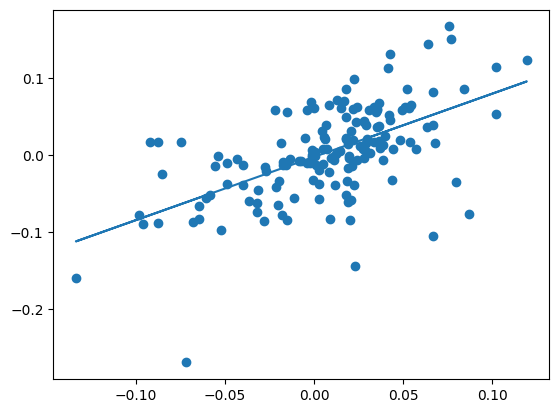

In [122]:
plt.scatter(log_monthly_market_returns, log_monthly_stock_returns)
plt.plot(log_monthly_market_returns, beta * (log_monthly_market_returns + alpha))